# Exploratory Analysis and features selection

In this notebook you will find: An univariate and linear data analysis, feature selection and an improvability score model.


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

In [4]:
df = pd.read_csv("data/student_data.csv")
df = df.drop(["FirstName", "FamilyName", "address"], axis=1)
target = df.FinalGrade
df.dtypes

StudentID      int64
school        object
sex           object
age            int64
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
FinalGrade     int64
dtype: object

## Categorical features selection

Filter-base feature selection of categorical features using Student's t-test. 


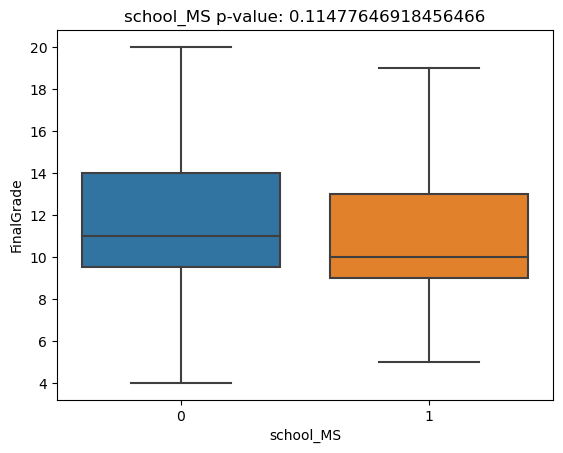

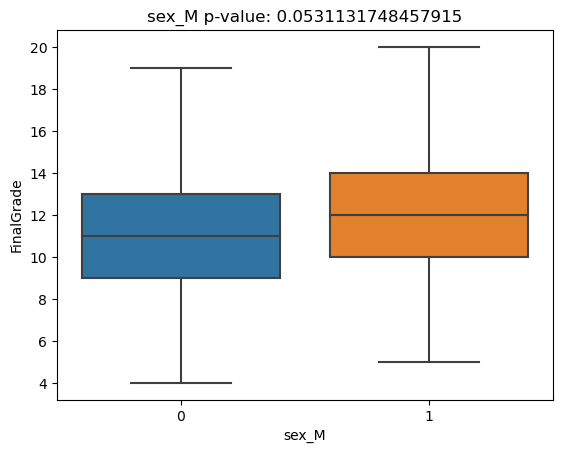

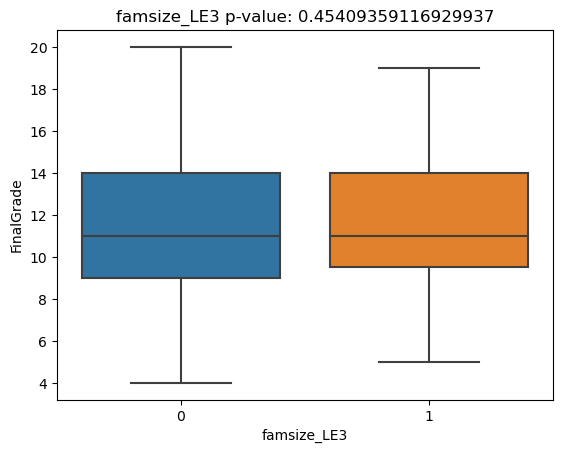

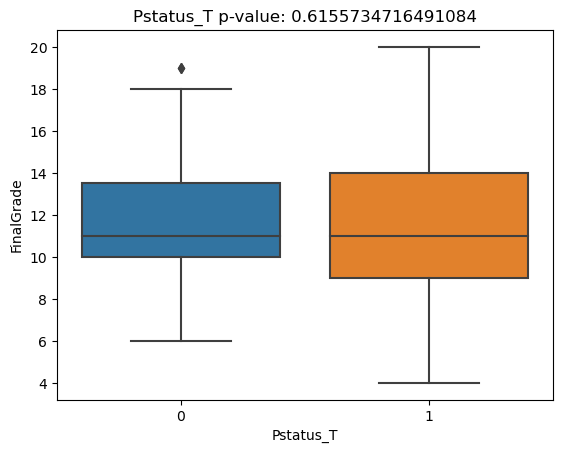

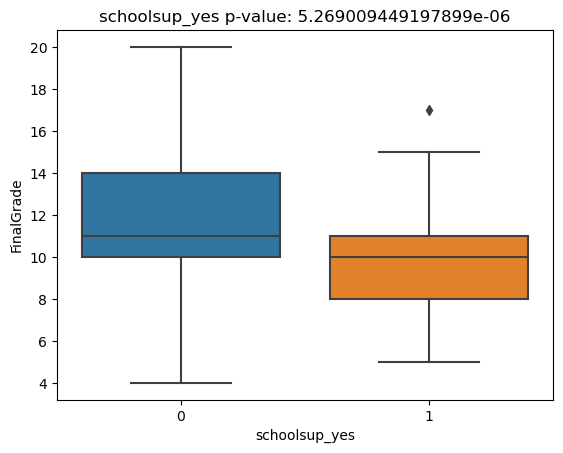

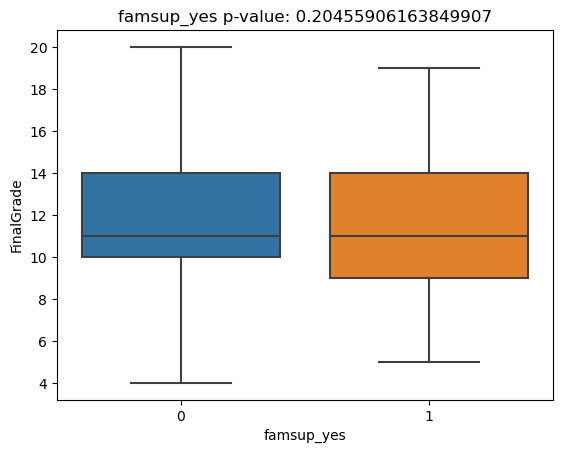

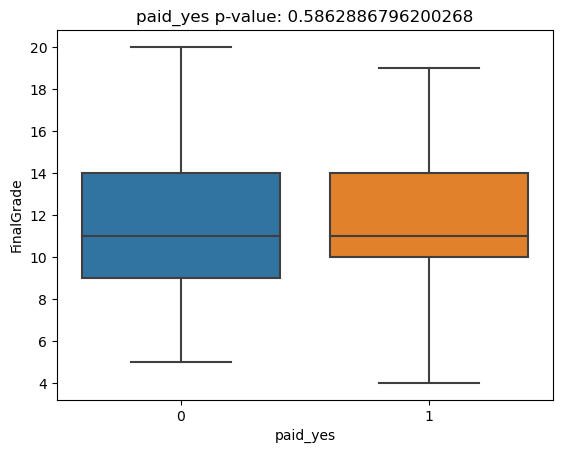

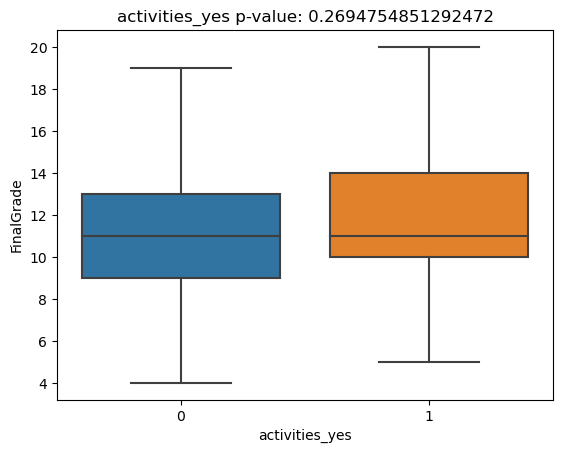

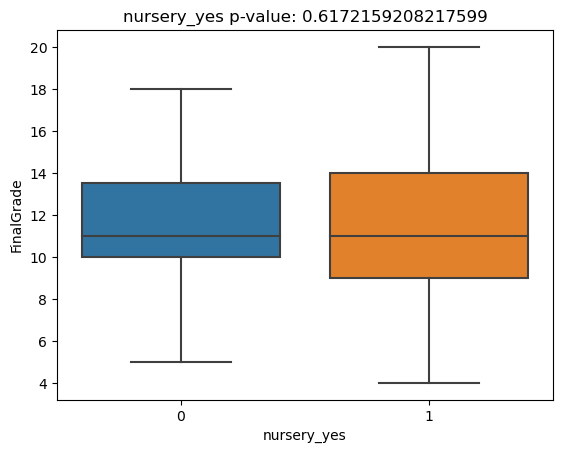

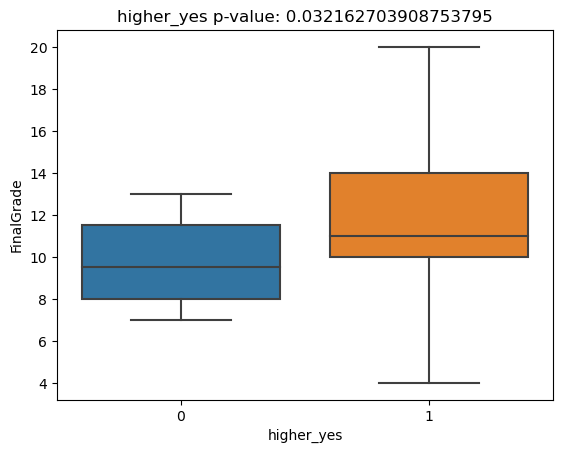

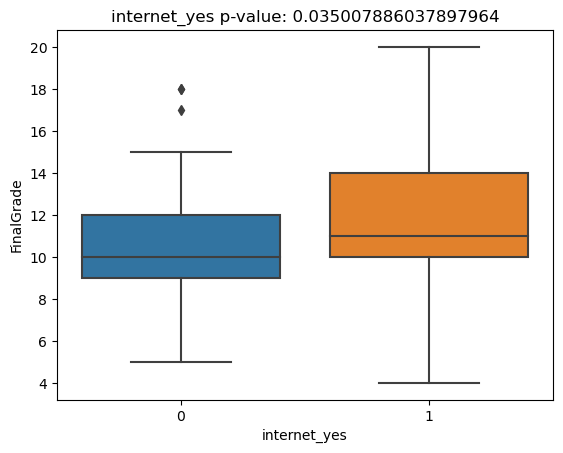

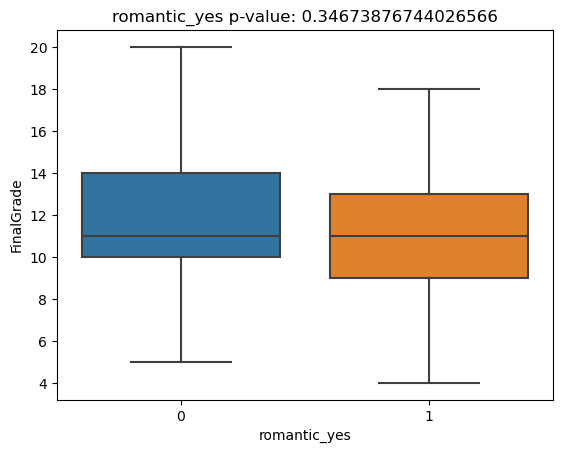

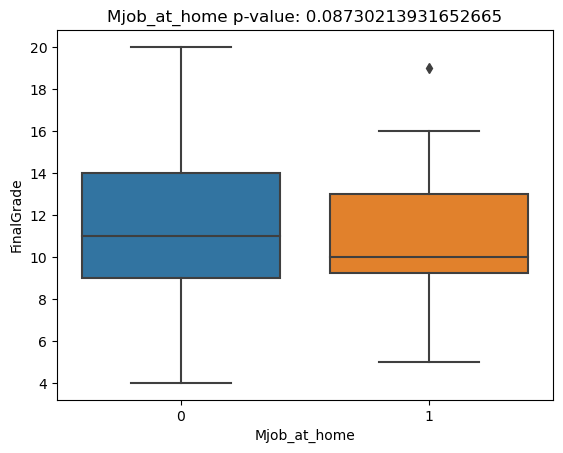

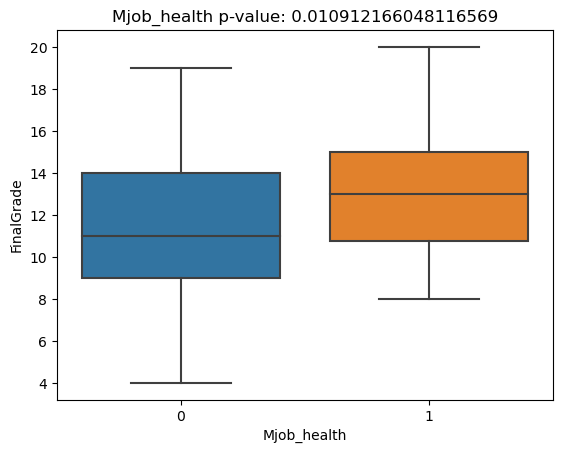

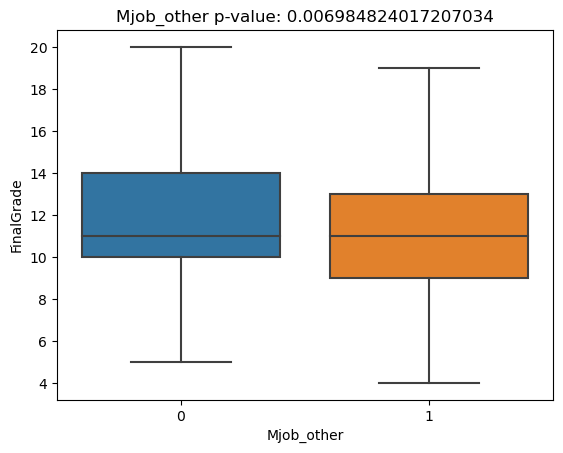

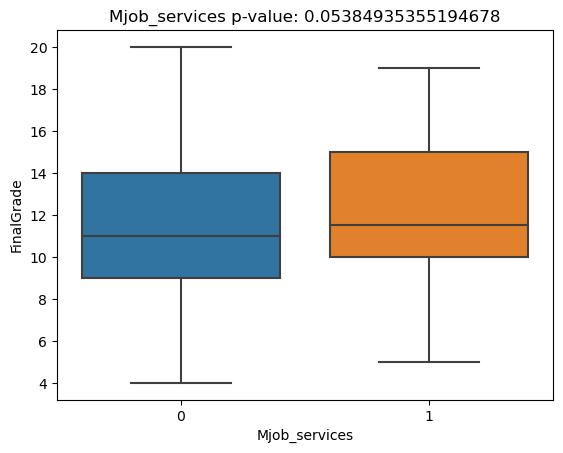

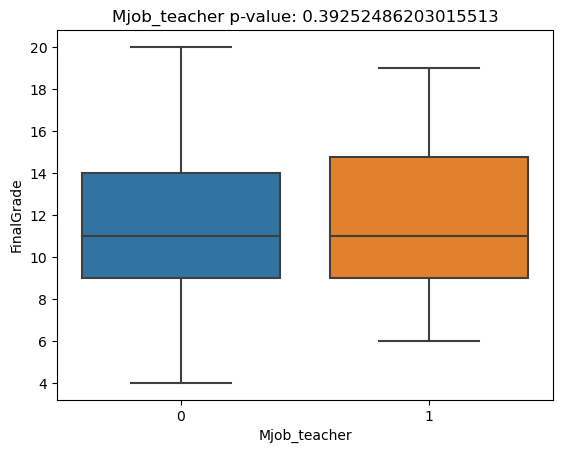

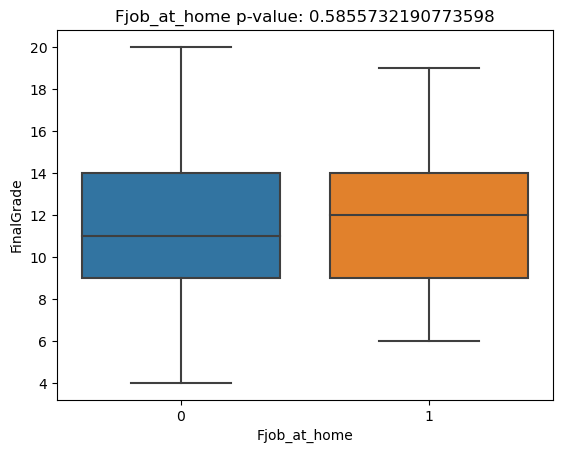

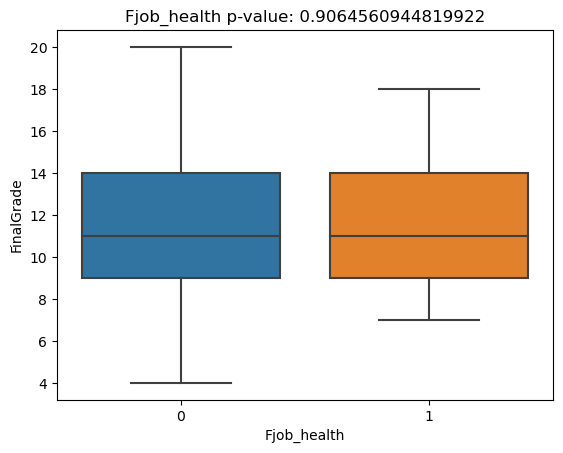

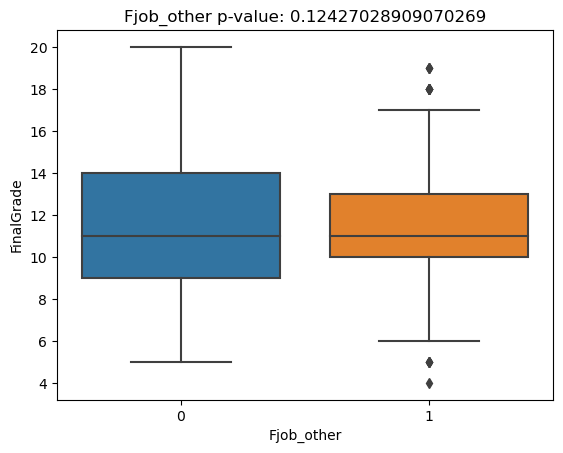

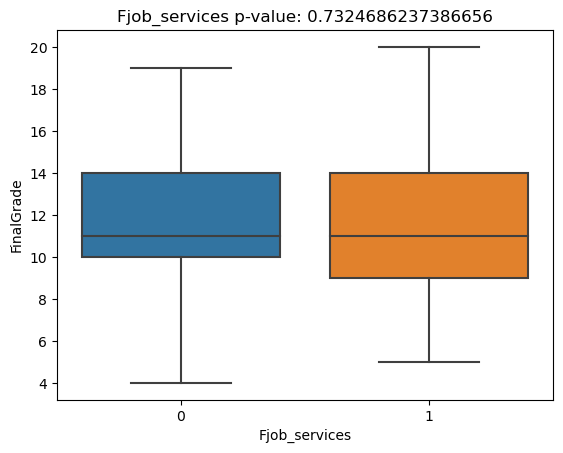

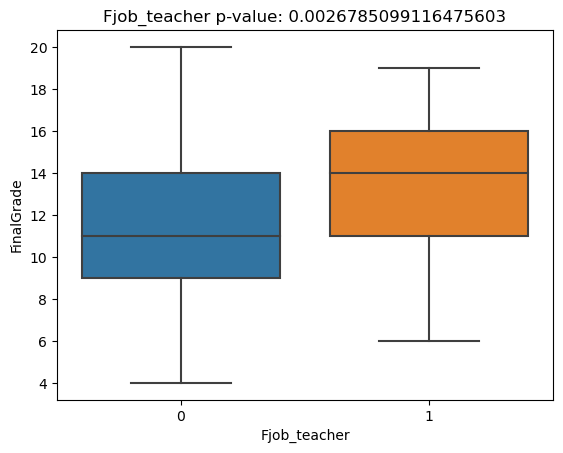

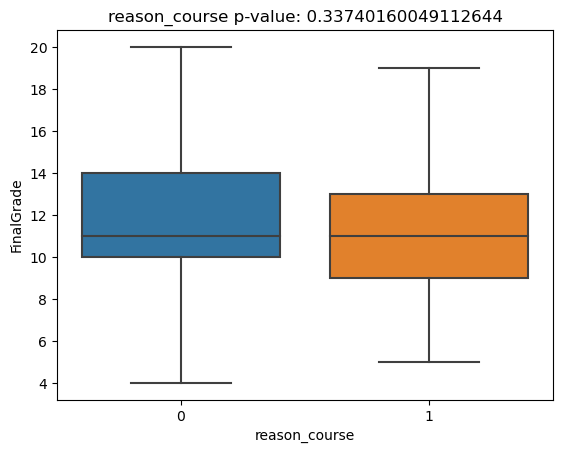

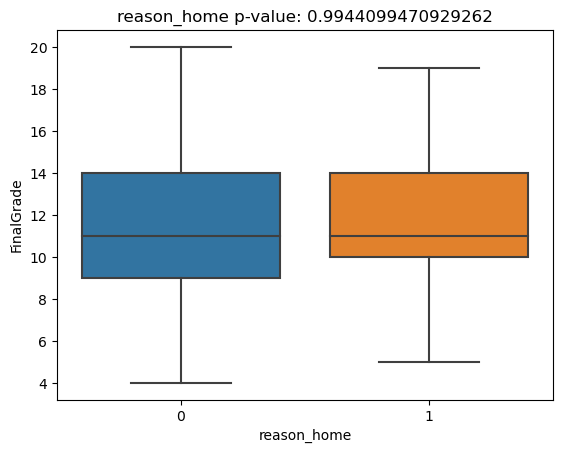

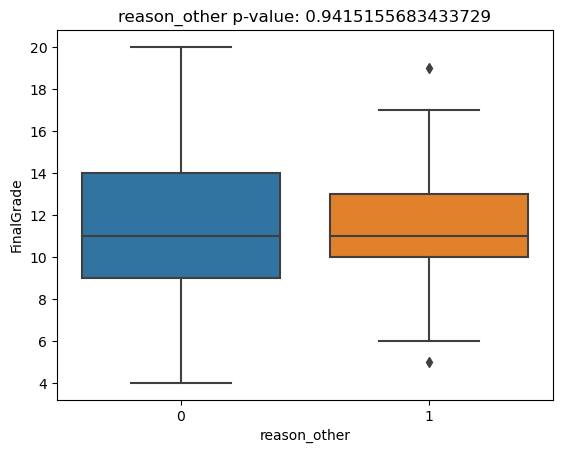

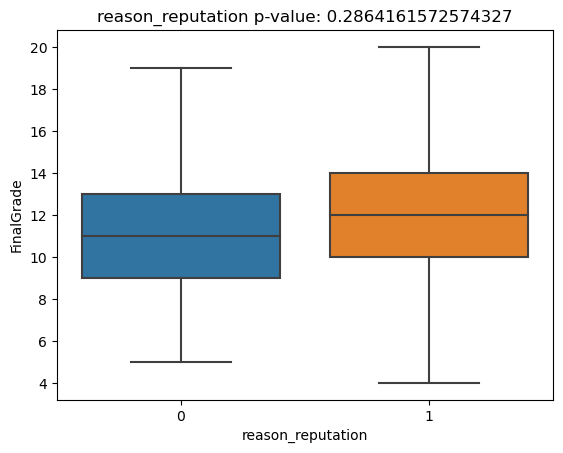

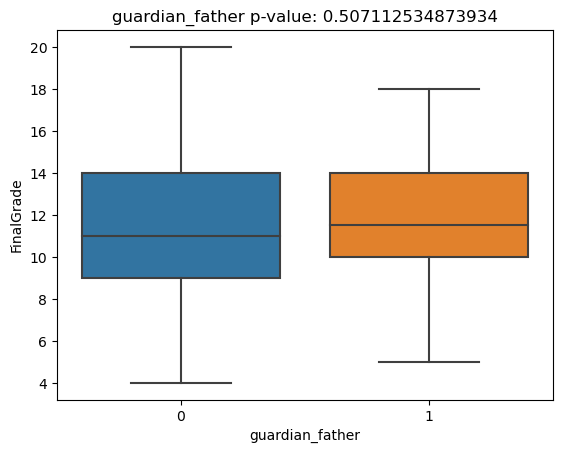

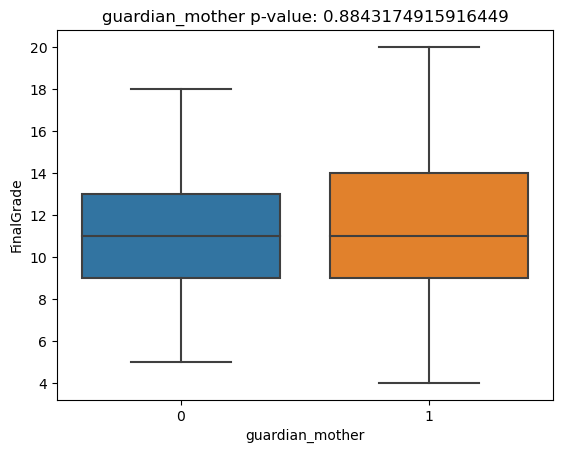

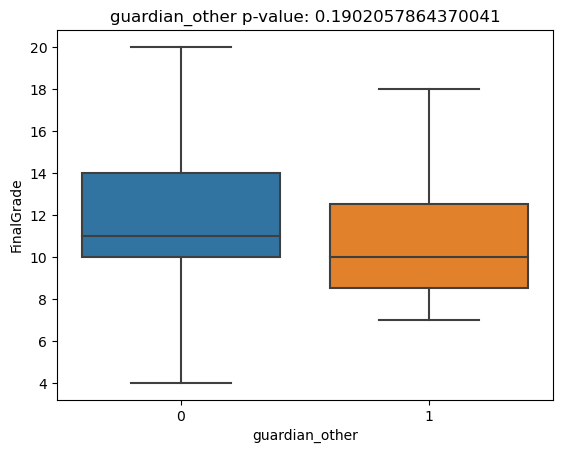

Selected categories: ['schoolsup_yes', 'higher_yes', 'internet_yes', 'Mjob_health', 'Mjob_other', 'Fjob_teacher']


In [5]:
# Analysis on categorical features only

df_cat = df.select_dtypes(include=[object])

is_binary = lambda x: len(set(x))==2

bin_feat = df_cat.apply(is_binary)
idx_bin_feat = bin_feat[bin_feat].index
idx_notbin_feat = bin_feat[bin_feat==0].index

df_bin = pd.get_dummies(df_cat[idx_bin_feat], drop_first=True)
df_notbin = pd.get_dummies(df_cat[idx_notbin_feat], drop_first=False)
df_cat_dum = pd.concat([df_bin, df_notbin], axis=1)


sel_cat_features = []
for cat in df_cat_dum.columns:
    idx_g1 = df_cat_dum.index[df_cat_dum[cat]==0]
    idx_g2 = df_cat_dum.index[df_cat_dum[cat]==1]
    ttest_res = ttest_ind(target[idx_g1], target[idx_g2])
    
    plt.figure()
    sns.boxplot(x=df_cat_dum[cat], y=target).set(title=f"{cat} p-value: {ttest_res.pvalue}")
    plt.show()
    
    if ttest_res.pvalue < 0.05:
        sel_cat_features.append(cat) 
    
print("Selected categories:", sel_cat_features)

## Numerical features selection

Filter-base feature selection of numerical features using Pearson correlation.

In [6]:
df_num = df.select_dtypes(exclude=[object]).drop(["StudentID"], axis=1)

sel_num_features = []
for col in df_num.columns.difference(["FinalGrade"]):
    pearson_corr = pearsonr(df_num[col], df_num.FinalGrade)
    print(col,":", pearson_corr)
    if pearson_corr[1] < 0.05:
        sel_num_features.append(col)
print("Selected features: ", sel_num_features)

Dalc : PearsonRResult(statistic=-0.140689763694483, pvalue=0.007763503306225161)
Fedu : PearsonRResult(statistic=0.15881054573241588, pvalue=0.0026190792237688657)
Medu : PearsonRResult(statistic=0.19030807288357734, pvalue=0.00029889275239106805)
Walc : PearsonRResult(statistic=-0.19005385331236407, pvalue=0.00030462250379934035)
absences : PearsonRResult(statistic=-0.21312853214380878, pvalue=4.9165382468461735e-05)
age : PearsonRResult(statistic=-0.14037178289305735, pvalue=0.007904820058623733)
failures : PearsonRResult(statistic=-0.29383090933749134, pvalue=1.5343959130995414e-08)
famrel : PearsonRResult(statistic=0.03771050597869598, pvalue=0.4775349429086896)
freetime : PearsonRResult(statistic=-0.02158866008358747, pvalue=0.6843586862888709)
goout : PearsonRResult(statistic=-0.17738279013112104, pvalue=0.0007612024151098847)
health : PearsonRResult(statistic=-0.08169095991485195, pvalue=0.12339758884635675)
studytime : PearsonRResult(statistic=0.1267280983875598, pvalue=0.01658

In [8]:
clean_df = pd.concat([df_cat_dum[sel_cat_features],
                      df_num[sel_num_features + ["FinalGrade"]]], axis=1)
clean_df

,schoolsup_yes,higher_yes,internet_yes,Mjob_health,Mjob_other,Fjob_teacher,Dalc,Fedu,Medu,Walc,absences,age,failures,goout,studytime,FinalGrade
0,1,1,0,0,0,1,1,4,4,1,6,18,0,4,2,6
1,0,1,1,0,0,0,1,1,1,1,4,17,0,3,2,6
2,1,1,1,0,0,0,2,1,1,3,10,15,3,2,2,10
3,0,1,1,1,0,0,1,2,4,1,2,15,0,2,3,15
4,0,1,0,0,1,0,1,3,3,2,4,16,0,2,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0,1,0,0,0,0,4,2,2,5,11,20,2,4,2,9
353,0,1,1,0,0,0,3,1,3,4,3,17,0,5,1,16
354,0,1,0,0,1,0,3,1,1,3,3,21,3,3,1,7
355,0,1,1,0,0,0,3,2,3,4,0,18,0,1,1,10


 ## Redondant features discrimination
 
 Redondant features discrimination using Pearson correlation

               schoolsup_yes  higher_yes  internet_yes  Mjob_health  \
schoolsup_yes       1.000000    0.039951     -0.019184    -0.070123   
higher_yes          0.039951    1.000000      0.067503     0.063394   
internet_yes       -0.019184    0.067503      1.000000     0.085035   
Mjob_health        -0.070123    0.063394      0.085035     1.000000   
Mjob_other          0.054168    0.029552     -0.053406    -0.233169   
Fjob_teacher        0.073258    0.056623     -0.022674    -0.050208   
Dalc               -0.024514   -0.048053      0.039318    -0.083963   
Fedu                0.027501    0.168567      0.131019     0.113401   
Medu               -0.064838    0.186744      0.181698     0.247226   
Walc               -0.096910   -0.093432      0.018620     0.018373   
absences           -0.000816   -0.113962      0.101567    -0.056523   
age                -0.247102   -0.203087     -0.107824    -0.084973   
failures            0.041085   -0.283880     -0.093288    -0.054008   
goout 

<Axes: >

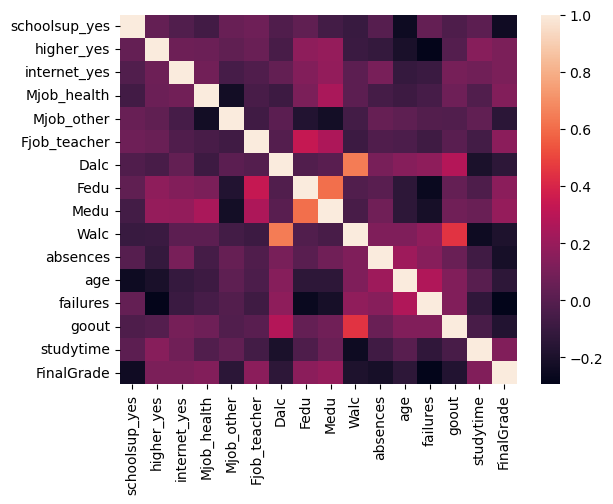

In [9]:
clean_df = pd.concat([df_cat_dum[sel_cat_features],
                      df_num[sel_num_features + ["FinalGrade"]]], axis=1)



corr = clean_df.corr()
print(corr)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Fedu et Medu strongly correlated (0.6), we only keep the one with the greatest correlation with the final grade (Medu).

Same for Dalc et Walc (we keep Walc).

## Model training

In [22]:
redondant_feat = ["Fedu", "Walc"]

NUMERICAL = [f for f in sel_num_features if f not in redondant_feat]
CATEGORICAL = [f for f in sel_cat_features if f not in redondant_feat]
FEATURES = NUMERICAL + CATEGORICAL
TARGET = "FinalGrade"

Here we tested differents models aiming to estimate the final grade expectation of a student regarding its caracteristics. The main concern is to avoid overfitting. The objective is not to perfectly fit the information about the student to its final grade but to estimate the final grade mathematical expectation considering the caracteristic of the student. 

We tested differents models and finally selected a gradient boosting regressor. For sanity check, we compare it to a dummy regressor which always output the mean of the train dataset.

In [16]:
n_estimators = 9000
model = GradientBoostingRegressor(max_depth=3, n_estimators=n_estimators, learning_rate=0.0003, 
                                  subsample=0.5)

model_dummy = DummyRegressor()


In [23]:
X = clean_df[FEATURES]
y = clean_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
model_dummy.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_test_dummy = model_dummy.predict(X_test)
y_pred_train_dummy = model_dummy.predict(X_train)

test_score = mean_squared_error(y_test, y_pred_test)
train_score = mean_squared_error(y_train, y_pred_train)
test_score_dummy = mean_squared_error(y_test, y_pred_test_dummy)
train_score_dummy = mean_squared_error(y_train, y_pred_train_dummy)


print(f"RMSE :\n train:", train_score, "test", test_score,\
      "\n Dummy:","train:", train_score_dummy, "test", test_score_dummy)



RMSE :
 train: 6.170958036886023 test 6.930882639839854 
 Dummy: train: 10.57758079409049 test 9.64771160357033


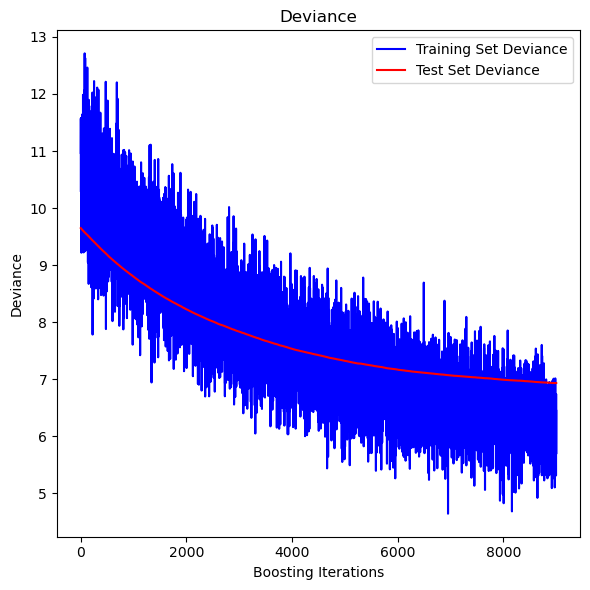

In [25]:
test_score = np.zeros((n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(n_estimators) + 1,
    model.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(n_estimators) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Model results and improvability score

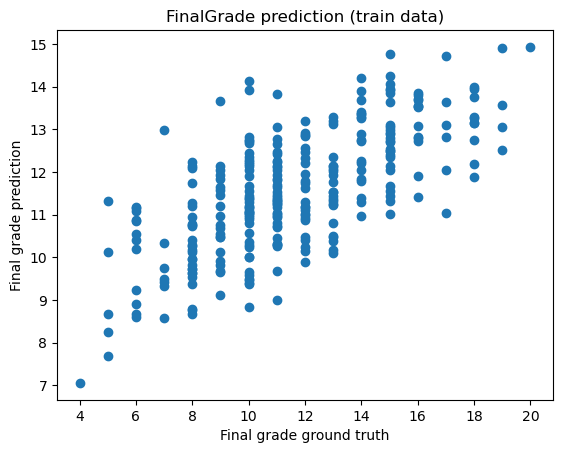

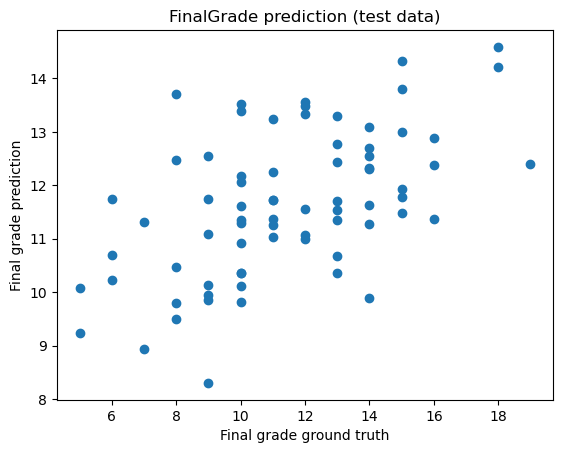

In [27]:
plt.figure()
plt.scatter(y_train, y_pred_train)
plt.title('FinalGrade prediction (train data)')
plt.xlabel("Final grade ground truth")
plt.ylabel("Final grade prediction")
plt.show()

plt.figure()
plt.scatter(y_test, y_pred_test)
plt.title('FinalGrade prediction (test data)')
plt.xlabel("Final grade ground truth")
plt.ylabel("Final grade prediction")

plt.show()

We define the improvability score as the difference between the predicted expected grade and the actual grade of the student

In [35]:
potential_grade = model.predict(X_test[FEATURES]) #- clean_df[TARGET]
improvement_factor = potential_grade - y_test

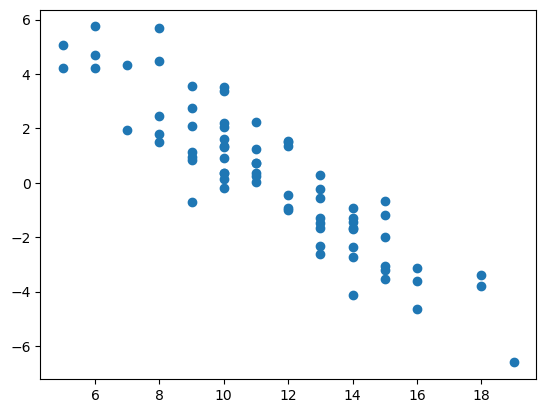

In [36]:

plt.figure()
plt.scatter(y_test, improvement_factor)
plt.show()